# **noisOut:** Denoising Diffusion Probabilistic Models

In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

### Dataset Investigation

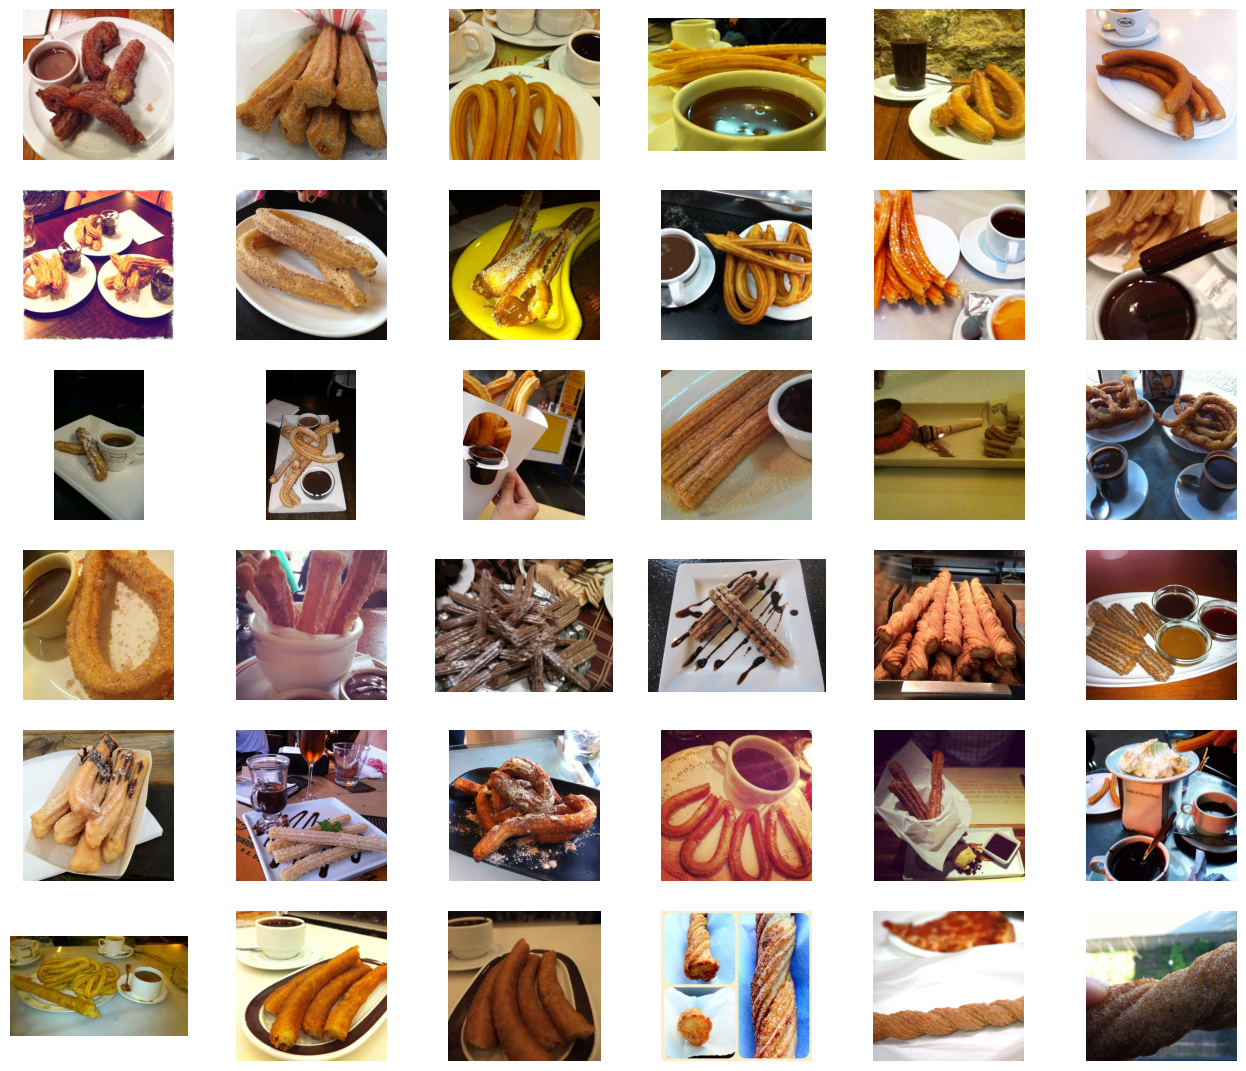

In [2]:
def show_images(dataset, num_samples=36, cols=6):
    rows = num_samples//cols + 1

    plt.figure(figsize=(16, 16))
    for i in range(num_samples):
        image, target = dataset[i]
        image = image.permute(1, 2, 0)
        image = image.numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

dataset = torchvision.datasets.Food101('./data', transform=torchvision.transforms.ToTensor(), download=True)
show_images(dataset)

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 64

In [4]:
def load_transformed_dataset():
    data_transforms = [
        torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),                  # [ 0, 1]
        torchvision.transforms.Lambda(lambda t: t*2 - 1)    # [-1, 1]  
    ]

    data_transform = torchvision.transforms.Compose(data_transforms)

    train = torchvision.datasets.Food101('./data', download=True, transform=data_transform, split='train')
    test = torchvision.datasets.Food101('./data', download=True, transform=data_transform, split='test')

    return torch.utils.data.ConcatDataset([train, test])

def load_reverse_transformed_dataset(images):
    reverse_transforms = [
        torchvision.transforms.Lambda(lambda t: (t+1) / 2), # [0, 1]
        torchvision.transforms.ToPILImage()
    ]

    reverse_transform = torchvision.transforms.Compose(reverse_transforms)

    return reverse_transform(images[0])

def show_images(pictures):
    num_pictures = len(pictures)
    fig, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 2, 2))

    if num_pictures == 1:
        axes = [axes]

    for idx, image in enumerate(pictures):
        ax = axes[idx]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy() if isinstance(image, torch.Tensor) else image)
        ax.axis('off')

    plt.show()

In [5]:
dataset = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)
dataloader

### **Diffusion Closed Form**

In [6]:
def beta_schedule(time_steps, start=0.0001, end=0.02):
    return torch.linspace(start, end, time_steps)

T = 1000

betas = beta_schedule(T)
betas_cumprod = torch.cumprod(betas, 0)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)

sqrt_alphas = torch.sqrt(alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

sqrt_betas = torch.sqrt(betas)
sqrt_betas_cumprod = torch.sqrt(betas_cumprod)

one_minus_alphas_cumprod = 1. - alphas_cumprod
one_minus_betas_cumprod = 1. - betas_cumprod

sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod)
sqrt_one_minus_betas_cumprod = torch.sqrt(one_minus_betas_cumprod)

variance = torch.zeros(T)
variance[1:] = betas[1:] * one_minus_alphas_cumprod[:-1] / one_minus_alphas_cumprod[1:]

In [7]:
next(iter(dataloader))[0].numpy()   # (B, C, H, W)

array([[[[ 0.082353  ,  0.12156868,  0.15294123, ...,  0.4901961 ,
           0.58431375,  0.654902  ],
         [ 0.07450986,  0.11372554,  0.12156868, ...,  0.48235297,
           0.5137255 ,  0.52156866],
         [ 0.04313731,  0.07450986,  0.06666672, ...,  0.45882356,
           0.48235297,  0.47450984],
         ...,
         [-0.60784316, -0.54509807, -0.49019605, ..., -0.42745095,
          -0.3960784 , -0.38039213],
         [-0.5921569 , -0.5294118 , -0.47450978, ..., -0.654902  ,
          -0.4980392 , -0.42745095],
         [-0.5686275 , -0.5137255 , -0.46666664, ..., -0.75686276,
          -0.5686275 , -0.4823529 ]],

        [[ 0.09019613,  0.13725495,  0.17647064, ...,  0.22352946,
           0.4431373 ,  0.5764706 ],
         [ 0.082353  ,  0.13725495,  0.17647064, ...,  0.15294123,
           0.23921573,  0.27058828],
         [ 0.082353  ,  0.13725495,  0.1686275 , ...,  0.09803927,
           0.12156868,  0.12156868],
         ...,
         [-0.73333335, -0.69411767

In [8]:
next(iter(dataloader))[1].numpy()   # (B, C, H, W)

array([ 9, 59, 80, 37, 17, 45, 21, 56, 29, 99, 28, 44, 45, 14, 75, 99, 84,
        2, 46, 54, 87, 15, 54, 12, 13,  6, 38, 32, 55, 53, 52, 62, 41,  9,
        5, 53, 47,  7, 12, 34, 17, 47,  0, 42, 43, 75, 30, 71, 85, 76, 27,
       51, 11, 79, 79, 27, 21,  4, 31, 82, 97, 63, 83, 37])

### **The Forward Pass**

In [9]:
def forward_diffusion(x_0, t, device='cpu'):
    B, C, H, W = x_0.shape
    
    t = t.repeat(B)
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]

    for _ in range(len(x_0.shape)-1):
        sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.unsqueeze(-1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.unsqueeze(-1)

    # re-parameterization trick
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

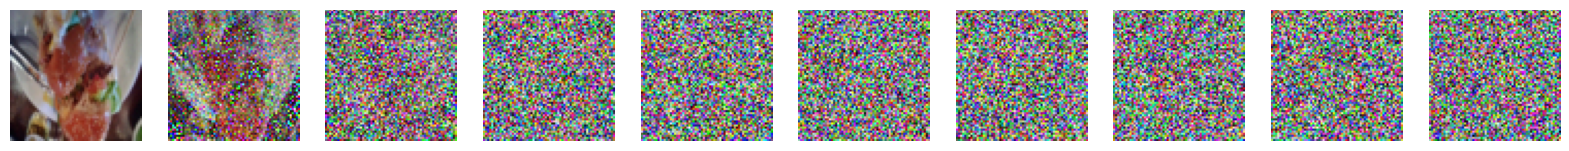

In [10]:
batch = next(iter(dataloader))
batch_images = batch[0]
batch_labels = batch[1]

num_images = 10
step_size = T // num_images

pictures = []
for idx, t in enumerate(range(0, T, step_size)):
    t = torch.tensor([t])
    images, noises = forward_diffusion(batch_images, t)
    image = load_reverse_transformed_dataset(images)
    pictures.append(image)

show_images(pictures)

### **The Backward Pass**

In [11]:
class SinusodialPositionEmbeddings(torch.nn.Module):

    def __init__(self, t_dim):
        super().__init__()
        self.t_dim = t_dim                                          

    def forward(self, t):
        t_dim = self.t_dim                                      # [0, t_dim]
        h_dim = self.t_dim//2                                   # [0, t_dim/2]
        i = torch.arange(h_dim, device=t.device, dtype=t.dtype) # (h_dim, )
        i = i.unsqueeze(0)                                      # (1, h_dim)
        t = t.unsqueeze(-1)                                     # (t, 1)
        x = t / (1000 ** (2 * i / self.t_dim))                  # (t, h_dim)
    
        emb = torch.cat([torch.sin(x)[:, :, None], torch.cos(x)[:, :, None]], dim=-1)   # (t, h_dim*2)  
        emb = emb.view(t.shape[0], self.t_dim)                                          # (t, t_dim)
        return emb

In [12]:
TIME_DIM = 1024
TIME_STEPS = 128

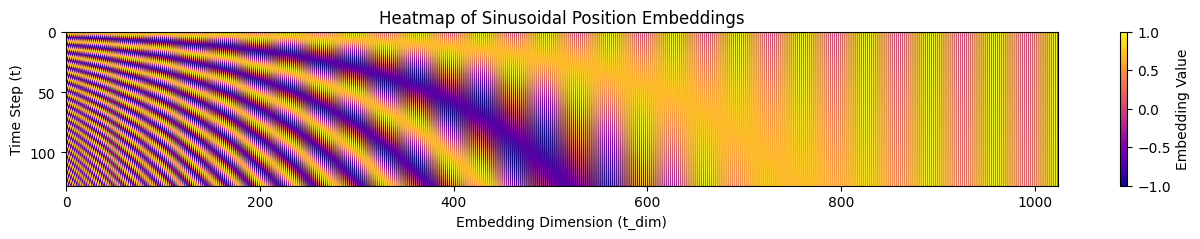

In [13]:
def show_heat_map(t_dim=TIME_DIM, t_steps=TIME_STEPS):
    embeddings = SinusodialPositionEmbeddings(t_dim)

    time_steps = torch.arange(0, t_steps)
    emb_matrix = embeddings(time_steps).detach().numpy()

    plt.figure(figsize=(16, 2))
    plt.imshow(emb_matrix, cmap='plasma', aspect='auto')
    plt.colorbar(label='Embedding Value')
    plt.title('Heatmap of Sinusoidal Position Embeddings')
    plt.xlabel('Embedding Dimension (t_dim)')
    plt.ylabel('Time Step (t)')
    plt.show();

show_heat_map(TIME_DIM, TIME_STEPS)

In [14]:
class Block(torch.nn.Module):

    def __init__(self, channels_in, channels_out, t_dim, sampling):
        super().__init__()

        self.t_mlp = torch.nn.Linear(t_dim, channels_out)
        self.sampling = sampling

        if sampling == 'up':
            self.conv_1 = torch.nn.Conv2d(2 * channels_in, channels_out, kernel_size=3, stride=1, padding=1)
            self.transform = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        if sampling == 'down':
            self.conv_1 = torch.nn.ConvTranspose2d(1 * channels_in, channels_out, kernel_size=3, stride=2, padding=1)
            self.transform = torch.nn.ConvTranspose2d(channels_out, channels_out, kernel_size=3, stride=2, padding=1)
        self.bnorm_1 = torch.nn.BatchNorm2d(channels_out)

        self.conv_2 = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        self.bnorm_2 = torch.nn.BatchNorm2d(channels_out)

        self.relu = torch.nn.ReLU()

    def forward(self, x, t):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.bnorm_1(x)

        t = self.t_mlp(t)
        t = t.view(t.shape[0], t.shape[1], 1, 1)

        x = x + t

        x = self.conv_2(x)
        x = self.relu(x)
        x = self.bnorm_2(x)

        x = self.transform(x)

        return x

In [15]:
class UNet(torch.nn.Module):

    def __init__(self, img_channels, t_dim):
        super().__init__()

        self.img_channels_in = img_channels
        self.img_channels_out = img_channels

        self.u_channels = (64, 128, 256, 512, 1024)
        self.d_channels = (1024, 512, 256, 128, 64)

        self.t_dim = t_dim

        self.t_mlp = torch.nn.Sequential(
            SinusodialPositionEmbeddings(self.t_dim),
            torch.nn.Linear(self.t_dim, self.t_dim),
            torch.nn.ReLU()
        )

        self.conv_in = torch.nn.Conv2d(self.img_channels_in, self.d_channels[0], kernel_size=3, stride=1, padding=1)

        self.d_sampling_blocks = torch.nn.ModuleList(
            [
                Block(self.u_channels[i], self.u_channels[i+1], t_dim, 'down')
                for i in range(len(self.u_channels)-1)
            ]
        )

        self.u_sampling_blocks = torch.nn.ModuleList(
            [
                Block(self.d_channels[i], self.d_channels[i+1], t_dim, 'down')
                for i in range(len(self.d_channels)-1)
            ]
        )

        self.conv_out = torch.nn.Conv2d(self.u_channels[-1], self.img_channels_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        t = self.t_mlp(t)

        x = self.conv_in(x)     

        residual_blocks = []

        for d_block in self.d_sampling_blocks:
            x = d_block(x, t)                           # (B, C, H, W)          
            residual_blocks.append(x)                   # (B, C, H, W)

        for u_block in self.u_sampling_blocks:
            r = residual_blocks.pop()                   # (B, C, H, W)
            x = u_block(torch.cat([x, r], dim=1), t)    # (B, C, H, W)

        x = self.conv_out(x)    


In [16]:
model = UNet(3, 32)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model

Number of parameters:  44040739


UNet(
  (t_mlp): Sequential(
    (0): SinusodialPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv_in): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_sampling_blocks): ModuleList(
    (0): Block(
      (t_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv_1): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (transform): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (t_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv_1): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(2, 2)